In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import tensorflow_probability as tfp

dist = tfp.distributions

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data

In [2]:
egg_timing_df = pd.read_csv("egg_times.csv",index_col=0)
egg_timing_df.head(n=10)

,weight,time,outcome
0,55.0,7.1,2
1,55.2,2.8,0
2,59.2,5.1,2
3,47.3,2.1,0
4,62.9,6.8,2
5,51.0,3.0,0
6,58.6,6.4,2
7,52.4,1.5,0
8,55.3,4.6,2
9,56.5,4.8,1


In [3]:
egg_timing_df = egg_timing_df.sample(frac=1).reset_index(drop=True)

train_ = egg_timing_df[['weight','time']].values # TensorFlow/Keras likes numpy/arrays rather than Dataframes
target_ = egg_timing_df['outcome'].values #.to_numpy()

train_in = train_[:-50] # get all except the last 50 for training
train_target = target_[:-50]

val_in = train_[-50:] # take all from the last 50 for validation
val_target = target_[-50:]

# Logger

In [4]:
class ShortLog(tf.keras.callbacks.Callback):

    def __init__(self, learning_rate = None):
        self.learning_rate = learning_rate
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.i = 0
        self.epoch = 0
        self.update_log = False
        self.epoch_loss = []

    def on_batch_end(self, batch, logs={}):
        
        self.losses.append(logs.get('loss'))
        self.i+=1
        
    def print_accuracy(self, logs):
        if 'val_sparse_categorical_accuracy' in logs:
            print("Accuracy:", logs.get('val_sparse_categorical_accuracy'))
        elif 'val_accuracy' in logs:
            print("Accuracy:", logs.get('val_accuracy'))
        else: print("Accuracy not found as metric in log keys: ", list(logs.keys()))
            
    def on_epoch_end(self, epoch, logs={}):
        if (self.epoch == 0 and self.learning_rate is not None):
            print("Learning rate:", learning_rate)
        
        self.epoch+=1
        if self.epoch%150==0:
            print("Epoch loss ({}):".format(self.epoch), sum(self.losses[-10:]) / 10)
            self.print_accuracy(logs)      
                
    def on_train_end(self, logs={}):
        print("Final loss:", sum(self.losses[-10:]) / 10, "at epoch:", str(self.epoch))
        self.final_string = "LR: {} final loss: {:.3f} at epoch {}".format(learning_rate, sum(self.losses[-10:]) / 10, self.epoch)
        print("[Final] ", end='')
        self.print_accuracy(logs)
        
log = ShortLog()

# Conventional dense model

In [32]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.Input(shape=(2,),name="basket"),
    tf.keras.layers.Dense(16, activation="relu", name="dense_1"),
    tf.keras.layers.Dense(6, activation="relu", name="dense_2"),
    tf.keras.layers.Dense(3, activation="softmax", name="out_pred"),
])

learning_rate = 1.0e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()
                      ])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/egg_times", histogram_freq=1)

### Class weights

In [10]:
n = len(target_)
num_underdone = sum(target_==0)
print(num_underdone / n)
num_softboiled = sum(target_==1)
print(num_softboiled / n)
num_hardboiled = sum(target_==2)
print(num_hardboiled / n)

softboiled_class_weight = 1.0

hardboiled_class_weight = num_softboiled / num_hardboiled
print(hardboiled_class_weight)

underdone_class_weight = num_softboiled / num_underdone
print(underdone_class_weight)

class_weights = {0:underdone_class_weight, 1:softboiled_class_weight, 2: hardboiled_class_weight}

0.3161189358372457
0.18309859154929578
0.5007824726134585
0.365625
0.5792079207920792


### Conventional model training

In [27]:
history = model.fit(train_, 
                    target_,
                    class_weight=class_weights,
                    epochs=500, 
                    verbose=0, 
                    use_multiprocessing=True, 
                    callbacks=[tensorboard_callback, log],
                    validation_split=0.1,
                    validation_freq=10)

Epoch loss (150): 0.11744973734021187
Accuracy: 0.84375
Epoch loss (300): 0.12729525417089463
Accuracy: 0.84375
Epoch loss (450): 0.12101710960268974
Accuracy: 0.84375
Final loss: 0.11332497745752335 at epoch: 500
Final accuracy: 0.84375


In [25]:
history = model.fit(train_, 
                    target_,
                    epochs=800, 
                    verbose=0, 
                    use_multiprocessing=True, 
                    callbacks=[tensorboard_callback, log],
                    validation_split=0.1,
                    validation_freq=25)

Epoch loss (150): 0.7881826400756836
Accuracy: 0.765625
Epoch loss (300): 0.554853355884552
Accuracy: 0.796875
Epoch loss (450): 0.3759600520133972
Accuracy: 0.8125
Epoch loss (600): 0.25002692341804506
Accuracy: 0.84375
Epoch loss (750): 0.2151302605867386
Accuracy: 0.859375
Final loss: 0.22033424377441407 at epoch: 800
Final accuracy: 0.859375


#### Overfitting

In [23]:
history = model.fit(train_, 
                    target_,
                    class_weight=class_weights,
                    epochs=2000, 
                    verbose=0, 
                    use_multiprocessing=True, 
                    callbacks=[tensorboard_callback, log],
                    validation_split=0.1,
                    validation_freq=25)

Epoch loss (150): 0.12781964018940925
Accuracy: 0.84375
Epoch loss (300): 0.11481734663248062
Accuracy: 0.84375
Epoch loss (450): 0.11937282159924507
Accuracy: 0.859375
Epoch loss (600): 0.11491901576519012
Accuracy: 0.859375
Epoch loss (750): 0.1100748434662819
Accuracy: 0.859375
Epoch loss (900): 0.11018935143947602
Accuracy: 0.875
Epoch loss (1050): 0.11020243018865586
Accuracy: 0.859375
Epoch loss (1200): 0.10533208325505257
Accuracy: 0.859375
Epoch loss (1350): 0.11466589495539665
Accuracy: 0.859375
Epoch loss (1500): 0.10010877698659897
Accuracy: 0.84375
Epoch loss (1650): 0.10901476144790649
Accuracy: 0.84375
Epoch loss (1800): 0.10481120273470879
Accuracy: 0.828125
Epoch loss (1950): 0.11046609058976173
Accuracy: 0.859375
Final loss: 0.10424004942178726 at epoch: 2000
Final accuracy: 0.859375


# Model 

### KL divergence function

In [6]:
dataset_size = len(train_)

kl_divergence_function = (lambda q, p, _: dist.kl_divergence(q, p) / tf.cast(dataset_size, dtype=tf.float32))

In [7]:
tf.keras.backend.clear_session()

model_tfp = tf.keras.Sequential([
    tf.keras.Input(shape=(2,),name="basket"),
    tfp.layers.DenseFlipout(16, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_1"),
    tfp.layers.DenseFlipout(6, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.relu, name="dense_tfp_2"),
    tfp.layers.DenseFlipout(3, kernel_divergence_fn=kl_divergence_function, activation=tf.nn.softmax, name="out_tfp_pred"),
])

learning_rate = 0.01

model_tfp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs/egg_times_tfp", histogram_freq=1)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [8]:
history = model_tfp.fit(train_, 
                    tf.one_hot(target_,3),
                    epochs=800, 
                    verbose=0, 
                    use_multiprocessing=True, 
                    callbacks=[tensorboard_callback, log],
                    validation_split=0.1,
                    validation_freq=25)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Epoch loss (150): 0.35134720206260683
Accuracy: 0.90625
Epoch loss (300): 0.32558682560920715
Accuracy: 0.84375
Epoch loss (450): 0.3078991651535034
Accuracy: 0.9375
Epoch loss (600): 0.30253618359565737
Accuracy: 0.921875
Epoch loss (750): 0.3097670912742615
Accuracy: 0.90625
Final loss: 0.3168871432542801 at epoch: 800
[Final] Accuracy: 0.90625


In [14]:
history = model_tfp.fit(train_, 
                    tf.one_hot(target_,3),
                    epochs=800, 
                    verbose=0, 
                    use_multiprocessing=True, 
                    callbacks=[tensorboard_callback, log],
                    validation_split=0.1,
                    validation_freq=25)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Epoch loss (150): 0.3622047811746597
Accuracy: 0.90625
Epoch loss (300): 0.286084321141243
Accuracy: 0.78125
Epoch loss (450): 0.33475127518177034
Accuracy: 0.890625
Epoch loss (600): 0.2971009910106659
Accuracy: 0.890625
Epoch loss (750): 0.2992729216814041
Accuracy: 0.90625
Final loss: 0.31931486427783967 at epoch: 800
Final accuracy: None


In [17]:
history = model_tfp.fit(train_, 
                    tf.one_hot(target_,3),
                    epochs=800, 
                    verbose=0, 
                    use_multiprocessing=True, 
                    callbacks=[tensorboard_callback, log],
                    validation_split=0.1,
                    validation_freq=25)

Epoch loss (150): 0.2784253627061844
Accuracy: 0.90625
Epoch loss (300): 0.2881740391254425
Accuracy: 0.890625
Epoch loss (450): 0.2943431407213211
Accuracy: 0.90625
Epoch loss (600): 0.3073088705539703
Accuracy: 0.890625
Epoch loss (750): 0.30731976628303526
Accuracy: 0.890625
Final loss: 0.30613012611866 at epoch: 800
[Final] Accuracy: 0.90625


# Training

In [86]:
history = model_tfp.fit(train_, 
                    tf.one_hot(target_,3),
                    epochs=10000, 
                    batch_size=50,
                    verbose=0, 
                    use_multiprocessing=False, 
                    callbacks=[tensorboard_callback, log],
                    validation_split=0.1,
                    validation_freq=50)

Epoch loss (150): 0.3543117523193359
Accuracy: 0.9165217280387878
Epoch loss (300): 0.3221668541431427
Accuracy: 0.9200000166893005
Epoch loss (450): 0.30578828454017637
Accuracy: 0.9217391014099121
Epoch loss (600): 0.27604193389415743
Accuracy: 0.9286956787109375
Epoch loss (750): 0.29383315742015836
Accuracy: 0.9321739077568054
Epoch loss (900): 0.28263588845729826
Accuracy: 0.9286956787109375
Epoch loss (1050): 0.27674171328544617
Accuracy: 0.9304347634315491
Epoch loss (1200): 0.2807096689939499
Accuracy: 0.9182608723640442
Epoch loss (1350): 0.31983613669872285
Accuracy: 0.9200000166893005
Epoch loss (1500): 0.3245747029781342
Accuracy: 0.9200000166893005
Epoch loss (1650): 0.26724470853805543
Accuracy: 0.9304347634315491
Epoch loss (1800): 0.2872628509998322
Accuracy: 0.9304347634315491
Epoch loss (1950): 0.2659541144967079
Accuracy: 0.9304347634315491
Epoch loss (2100): 0.3526884883642197
Accuracy: 0.9321739077568054
Epoch loss (2250): 0.2806111454963684
Accuracy: 0.93217390775

In [110]:
p_y = model_tfp.predict(val_in[0:3])

In [111]:
p_y

array([[9.7302532e-01, 2.6940122e-02, 3.4577453e-05],
       [5.6059127e-07, 4.8573419e-02, 9.5142603e-01],
       [3.5287307e-03, 7.8340000e-01, 2.1307127e-01]], dtype=float32)

In [119]:
p_y = model_tfp.predict(val_in[0:3])

In [116]:
p_y

array([[9.9263990e-01, 7.3517268e-03, 8.4542480e-06],
       [4.3721265e-08, 1.9469375e-02, 9.8053062e-01],
       [4.2997794e-03, 8.9077187e-01, 1.0492835e-01]], dtype=float32)

In [117]:
dist.Categorical(logits=p_y).log_prob(val_target[0:3])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.5561423, -0.5639485, -0.6247838], dtype=float32)>

In [120]:
dist.Categorical(logits=p_y).log_prob(val_target[0:3])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.5624086 , -0.56205064, -0.73526317], dtype=float32)>

In [127]:
s = np.array([dist.Categorical(logits=p_y).sample().numpy() for i in range(100)])

(array([26., 45., 29.]),
 array([0, 1, 2, 3]),
 <BarContainer object of 3 artists>)

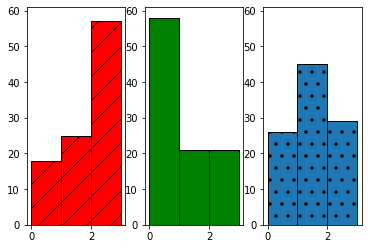

In [122]:
ax1 = plt.subplot(1,3,1)
ax1.hist(s[:,1].reshape(-1,1),bins=[0,1,2,3],density=False, hatch="/", color='r', edgecolor='black')
ax = plt.subplot(1,3,2, sharey=ax1)
ax.hist(s[:,0].reshape(-1,1),bins=[0,1,2,3],density=False, color='g', edgecolor='black')
ax = plt.subplot(1,3,3,sharey=ax1)
ax.hist(s[:,2].reshape(-1,1),bins=[0,1,2,3],density=False, hatch=".", edgecolor='black')